In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import json
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation

import tensorflow as tf
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from matplotlib import pyplot as plt
import cv2


In [2]:
# Load image and mask paths
def load_image_paths(base_dir, scene_id):
    #before_image1 = os.path.join(base_dir, f'{scene_id}_change-0.png')
    before_image1 = base_dir + '/' + scene_id + '_change-0.png'
    #after_image1 = os.path.join(base_dir, f'{scene_id}_change-1.png')
    after_image1 = base_dir + '/' + scene_id + '_change-1.png'
    #mask = os.path.join(base_dir, f'{scene_id}_mask.png')
    mask = base_dir + '/' + scene_id + '_mask.png'
    return before_image1, after_image1, mask

In [3]:
# Data generator
class ChangeDetectionDataset(tf.keras.utils.Sequence):
    def __init__(self, image_pairs = None, masks = None, batch_size=4, image_size=(256, 256), shuffle=True):
        self.json_file = open('utils/synthetic_anno.json')
        self.coco = json.load(self.json_file) 
        self.process_images()
        if(image_pairs is None and masks is None):
            self.image_pairs, self.masks = self.get_image_pairs_and_masks('data/renders_multicam_diff_1')
        else:
            self.image_pairs = image_pairs
            self.masks = masks
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.image_pairs))
        #self.on_epoch_end()
        
    def get_image_pairs_and_masks(self, base_dir):
        image_pairs = []
        masks = []
        
        scene_ids = [item['scene'] for item in self.coco['images']]
        
        for scene_id in scene_ids:
            before_image1, after_image1, mask = load_image_paths(base_dir, scene_id)
            image_pairs.append((before_image1, after_image1))
            masks.append(mask)
            
            
        return image_pairs, masks
    
    def __len__(self):
        return int(np.ceil(len(self.image_pairs) / self.batch_size))
    
    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_image_pairs = [self.image_pairs[i] for i in indices]
        batch_masks = [self.masks[i] for i in indices]
        
        #X1, X2, y = self.__data_generation(batch_image_pairs, batch_masks)
        X, y = self.__data_generation(batch_image_pairs, batch_masks)
        #return [X1, X2], y
        return X, y
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_pairs))
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    # def __data_generation(self, batch_image_pairs, batch_masks):
    #     X1 = np.zeros((self.batch_size, *self.image_size, 3), dtype=np.float32)
    #     X2 = np.zeros((self.batch_size, *self.image_size, 3), dtype=np.float32)
    #     y = np.zeros((self.batch_size, *self.image_size, 3), dtype=np.float32)  # 3 channels for color-coded mask
        
    #     for i, (img_paths, mask_path) in enumerate(zip(batch_image_pairs, batch_masks)):
    #         before_img = img_to_array(load_img(img_paths[0], target_size=self.image_size)) / 255.0
    #         after_img = img_to_array(load_img(img_paths[1], target_size=self.image_size)) / 255.0
    #         mask = img_to_array(load_img(mask_path, target_size=self.image_size)) / 255.0
            
    #         X1[i, :, :, :] = before_img
    #         X2[i, :, :, :] = after_img
    #         y[i, :, :, :] = mask
        
    #     return X1, X2, y
    
    def __data_generation(self, batch_image_pairs, batch_masks):
        X = np.zeros((self.batch_size, *self.image_size, 6), dtype=np.float32)  # 6 channels for concatenated images
        y = np.zeros((self.batch_size, *self.image_size, 4), dtype=np.float32)  # 3 channels for color-coded mask
        
        for i, (img_paths, mask_path) in enumerate(zip(batch_image_pairs, batch_masks)):
            before_img = img_to_array(load_img(img_paths[0], target_size=self.image_size)) / 255.0
            after_img = img_to_array(load_img(img_paths[1], target_size=self.image_size)) / 255.0
            mask = img_to_array(load_img(mask_path, target_size=self.image_size)) / 255.0

            mask = self.rgb_to_onehot(mask)
            
            X[i, :, :, :3] = before_img
            X[i, :, :, 3:] = after_img
            y[i, :, :, :] = mask
        
        return X, y
    
    def process_images(self):
        self.images = {}
        for image in self.coco['images']:
            image_id = image['id']
            if image_id in self.images:
                print("ERROR: Skipping duplicate image id: {}".format(image))
            else:
                self.images[image_id] = image

    def rgb_to_onehot(self, rgb_image):
        onehot_image = np.zeros((rgb_image.shape[0], rgb_image.shape[1], 4), dtype=np.float32)
        onehot_image[(rgb_image == [0, 0, 0]).all(axis=-1)] = [1, 0, 0, 0]     # Background
        onehot_image[(rgb_image == [255, 0, 0]).all(axis=-1)] = [0, 1, 0, 0]   # Red (Taken)
        onehot_image[(rgb_image == [0, 255, 0]).all(axis=-1)] = [0, 0, 1, 0]   # Green (Added)
        onehot_image[(rgb_image == [0, 0, 255]).all(axis=-1)] = [0, 0, 0, 1]   # Blue (Shifted)
        return onehot_image
    

In [4]:
def onehot_to_rgb(onehot_mask):
    rgb_image = np.zeros((onehot_mask.shape[0], onehot_mask.shape[1], 3), dtype=np.float32)
    rgb_image[onehot_mask[:, :, 0] == 1] = [0, 0, 0]   # Background
    rgb_image[onehot_mask[:, :, 1] == 1] = [255, 0, 0] # Red (Taken)
    rgb_image[onehot_mask[:, :, 2] == 1] = [0, 255, 0] # Green (Added)
    rgb_image[onehot_mask[:, :, 3] == 1] = [0, 0, 255] # Blue (Shifted)
    return rgb_image

In [5]:
dataset = ChangeDetectionDataset()

print(dataset.images)

{0: {'id': 0, 'license': 1, 'scene': '0101050fe5ed48399f99247e7534d6e2/stcg.us.0003_0101050fe5ed48399f99247e7534d6e2_cam-0', 'width': 1280, 'height': 720, 'randommats1': '0101050fe5ed48399f99247e7534d6e2/stcg.us.0003_0101050fe5ed48399f99247e7534d6e2_cam-0_change-0-randommats.png', 'randommats2': '0101050fe5ed48399f99247e7534d6e2/stcg.us.0003_0101050fe5ed48399f99247e7534d6e2_cam-0_change-1-randommats.png', 'depth1': '0101050fe5ed48399f99247e7534d6e2/stcg.us.0003_0101050fe5ed48399f99247e7534d6e2_cam-0_change-0-depth0001.exr', 'depth2': '0101050fe5ed48399f99247e7534d6e2/stcg.us.0003_0101050fe5ed48399f99247e7534d6e2_cam-0_change-1-depth0001.exr', 'image1': '0101050fe5ed48399f99247e7534d6e2/stcg.us.0003_0101050fe5ed48399f99247e7534d6e2_cam-0_change-0.png', 'image2': '0101050fe5ed48399f99247e7534d6e2/stcg.us.0003_0101050fe5ed48399f99247e7534d6e2_cam-0_change-1.png'}, 1: {'id': 1, 'license': 1, 'scene': '0101050fe5ed48399f99247e7534d6e2/stcg.us.0003_0101050fe5ed48399f99247e7534d6e2_cam-1', 'w

In [57]:
X, y_true = dataset.__getitem__(0)
print(dataset.image_pairs[0])
print(y_true.shape)

('data/renders_multicam_diff_1/0101050fe5ed48399f99247e7534d6e2/stcg.us.0003_0101050fe5ed48399f99247e7534d6e2_cam-0_change-0.png', 'data/renders_multicam_diff_1/0101050fe5ed48399f99247e7534d6e2/stcg.us.0003_0101050fe5ed48399f99247e7534d6e2_cam-0_change-1.png')
(4, 256, 256, 4)


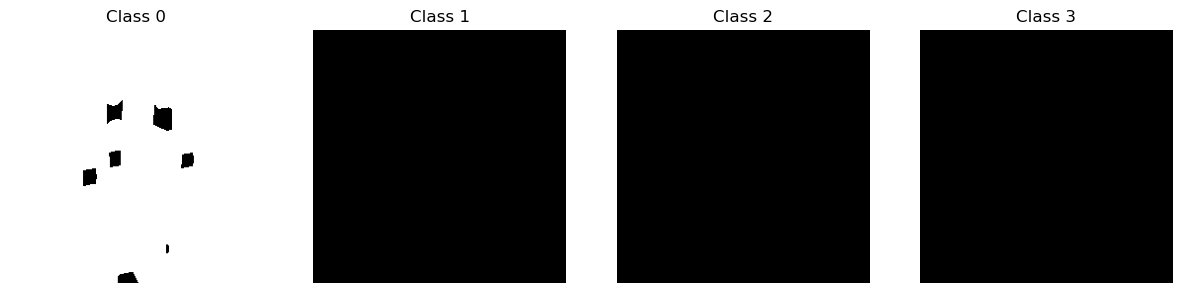

In [58]:
num_classes = y_true.shape[-1]

plt.figure(figsize=(15, 5))
for i in range(num_classes):
    plt.subplot(1, num_classes, i + 1)
    plt.imshow(y_true[0, :, :, i], cmap='gray')
    plt.title(f'Class {i}')
    plt.axis('off')

plt.show()

In [65]:
y_new = dataset.rgb_to_onehot(y_true[0, :, :, 0])

ValueError: operands could not be broadcast together with shapes (256,256) (3,) 

In [62]:
y_new = onehot_to_rgb(y_new)

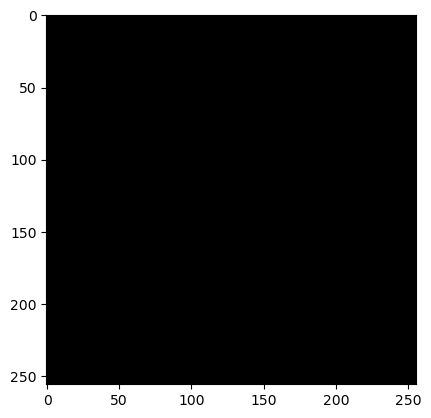

In [63]:
plt.imshow(y_new)